# 02. PyTorch Neural Network Classification

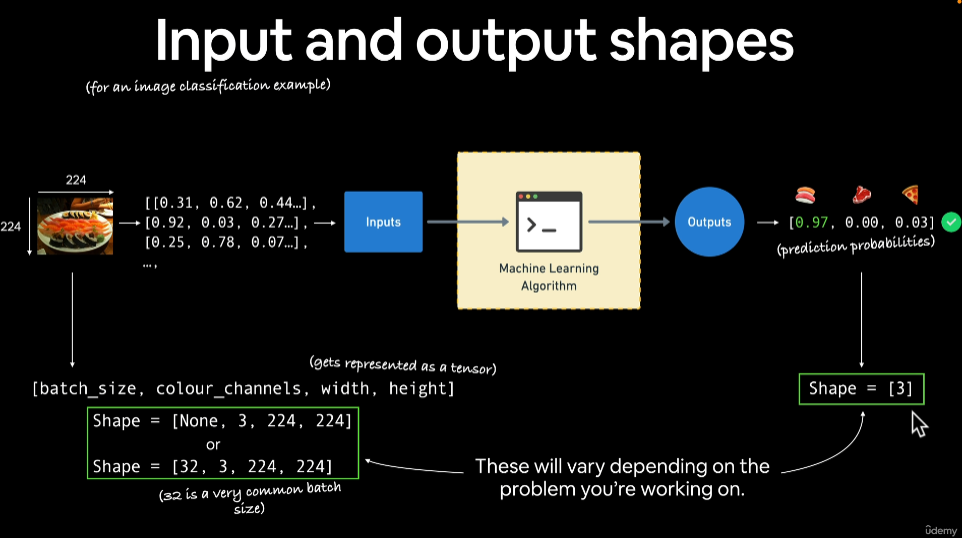

### 0.Architecture of a classification neural network 

- Input shape === same as input features 
- Hidden layer(s) === Problem specific (min = 1)
- Neurons per hidden layer === problem specific generally 10-512
- Output layer shape === 1 (`out_features`)
- Activations === usually ReLU , sigmoid for output layer 
- Loss function === Cross-entropy 
- Optimizer 

### 1.Make classification data ready 


In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Lets print it out
print(f"First 5 features of X : {X[:5]} \n")
print(f"First 5 features of y : {y[:5]}\n")

First 5 features of X : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

First 5 features of y : [1 1 1 1 0]



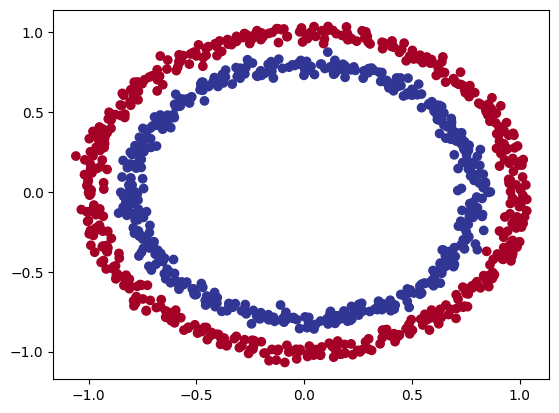

In [2]:
# Visualize data 
import matplotlib.pyplot as plt 
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu)

In [3]:
# input and output shape
print("Input and Output shape" ,X.shape , y.shape)

import torch 
# Turn data to tensor and create train test split 
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5] , y[:5]

Input and Output shape (1000, 2) (1000,)


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [4]:
# splitting up the data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y ,stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

### 2.Build the model

1. Set up device agnostic code 

2. Constructing a model by sub-class `nn.Modulde`

3. Setup the loss fucntion and optimizer

4. Creating a training loop

5. Evaluate the model 


In [5]:
import torch 
from torch import nn

# 1. Set up device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Constructing a model by sub-class `nn.Modulde` 
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # computer layer_1 then pass that to layer_2

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [6]:
# same model above using nn.Sequentail 
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features =5),
    nn.Linear(in_features = 5, out_features =1)
)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Although `nn.Sequential` seems like 100pc way better, but the `nn.Module` give more control and help in build complex networks. The above `class CircleModelV0` can be written with `nn.Sequentail` too.

In [7]:
class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
    nn.Linear(in_features = 2, out_features =5),
    nn.Linear(in_features = 5, out_features =1)
    )

    def forward(self,x):
        return self.layers(x)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
model_0.to(device)
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}")
print(f"Length of test samples : {len(X_test)}, shape : {X_test.shape}")
print(f"First 10 samples : {X_test[:10]}")
print(f"First 10 labels : {y_test[:10]}")

Length of predictions : 200
Length of test samples : 200, shape : torch.Size([200, 2])
First 10 samples : tensor([[ 0.7263,  0.3669],
        [-0.3566, -0.9548],
        [-0.0800, -0.9602],
        [-0.8264, -0.5212],
        [-0.3654,  0.7202],
        [ 0.5935,  0.5540],
        [ 0.8099, -0.1387],
        [ 0.0764,  0.7993],
        [-0.1646,  0.9925],
        [ 0.7584, -0.7182]])
First 10 labels : tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.])


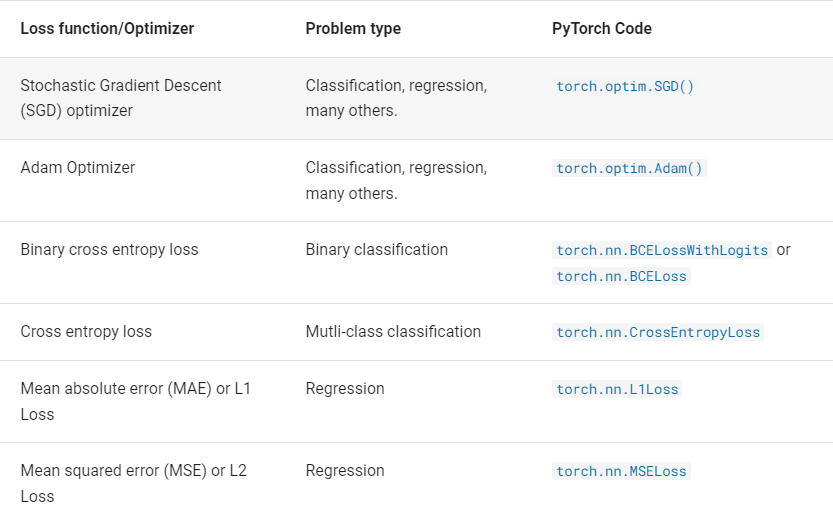

PyTorch has 2 binary-cross entropy losses 

* `torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
* `torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in

but the docs state that `torch.nn.BCEWithLogitsLoss()` is more stable after a sigmoid layer

In [9]:
# 3. Setup the loss fucntion and optimizer

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)

# Accuracy metrics 

def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item() # torch.eq() calculates which tensors are equal
    acc = correct/len(y_preds)
    return acc

Trainig Model involves , PyTorch training loop steps :-

1. **Forward pass -**  The model goes through all the training data once, performing its `forward()` function calculations `model(x_train)`

2. **Calculating the loss -** The model outputs predcitions that are compared with ground truth ( `loss = loss_fn(y_preds, y_train)`)

3. **Zero gradients -** The optimizer gradients are set to zero ( they are accumulated by default) `optimizer.zero_grad()`

4. **Perform backpropagation on loss -** Perform the backpropagation `loss.backward()`

5. **Step the optimizer (gradient descent) -** `optimizer.step()`


The raw outputs of our model are often referred to as **logits.**

In [10]:
# 3. Train the model
y_logits = model_0(X_test.to(device))[:5]
print("The first 5 values : ",y_logits)

# Use sigmoid on model logits 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

The first 5 values :  tensor([[ 0.0350],
        [-0.4475],
        [-0.4453],
        [-0.3014],
        [ 0.1435]], device='cuda:0', grad_fn=<SliceBackward0>)


tensor([[0.5087],
        [0.3900],
        [0.3905],
        [0.4252],
        [0.5358]], device='cuda:0', grad_fn=<SigmoidBackward0>)

They're now in the form of **prediction probabilities** 

More specificially:
* If `y_pred_probs` >= 0.5, y=1 (class 1)
* If `y_pred_probs` < 0.5, y=0 (class 0)

In [11]:
# Find the predicted labels 
y_pred = torch.round(y_pred_probs)


y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check the equality 
print(torch.eq(y_pred_labels.squeeze(),y_pred.squeeze()))

# Get rid of extra dim
y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [12]:
# Building a training and testing loops 

torch.manual_seed(42)

# set the number of epochs
epochs = 200

# Put data to target devices 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build the training and eval loop 
for epoch in range(epochs):
    ### Training 
    model_0.train()

    # Forward pass 
    y_logits =  model_0(X_train).squeeze() # remove extra 1 dim
    y_pred = torch.round(torch.sigmoid(y_logits))

    #calculate the loss 
    loss = loss_fn(y_pred, y_train)

    acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

    # Optimizer zero grad 
    optimizer.zero_grad()
    # backpropagation 
    loss.backward()
    # Optimizer step
    optimizer.step()

    ### Testing
    with torch.inference_mode():
        # Foarward pass 
        test_logits = model_0(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits.squeeze()))

        # Calculate the loss
        test_loss = loss_fn(test_logits.squeeze(),y_test.squeeze())

        test_acc = accuracy_fn(y_true=y_test,y_preds=test_pred) 

    # print out what's happening 
    if epoch % 10 == 0:
        print(f"Epoch : {epoch:.2f} | Loss : {loss:.2f} | Accuracy : {acc:.2f} | Test loss : {test_loss:.2f} | Test acc : {test_acc:.2f}")

Epoch : 0.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 10.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 20.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 30.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51


Epoch : 40.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 50.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 60.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 70.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 80.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 90.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 100.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 110.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 120.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 130.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 140.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.51
Epoch : 150.00 | Loss : 0.75 | Accuracy : 0.48 | Test loss : 0.70 | Test acc : 0.5

5. Evaluate the model 

We'll write some code to download and import the `helper_functions.py` script from the Learn PyTorch for Deep Learning repo.

Link - https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

In [13]:
# download the scrip

import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
    print("The file exists")
else:
    print("Downloading......")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

The file exists


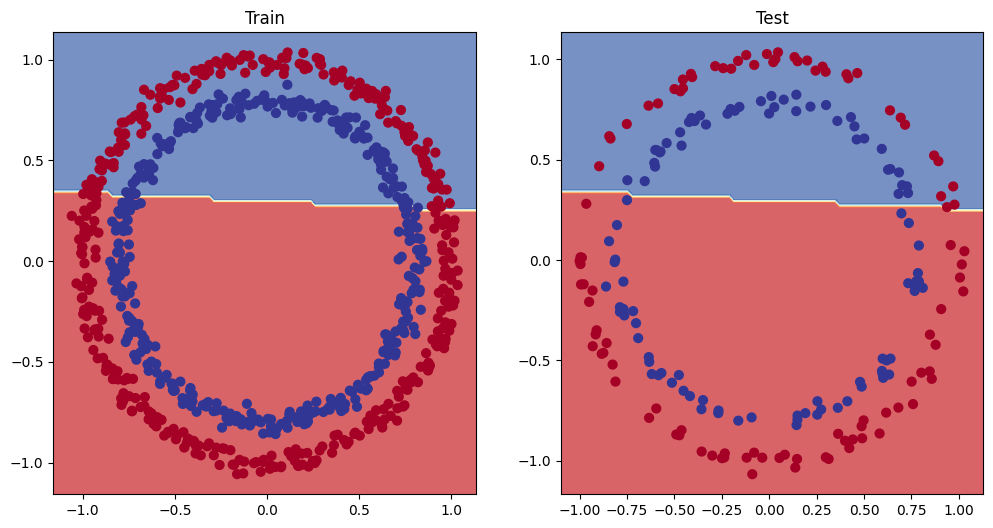

In [14]:
# use the functions inside the files for plotting 
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


#### Improve the model (from model perspective)

The model seem to be learning nothing as the accuracy and loss is not changing after certain epochs.

![Alt text](image.png)


Now , let's add extra layers and few more epochs, (`epochs = 1000`)

In [15]:
# Model defining 

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
        
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [16]:
# Loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lr = 0.01, params = model_1.parameters())

In [17]:
# Training process
model_1.to(device)
epochs = 1000 # more epochs

X_train,X_test = X_train.to(device), X_test.to(device)
y_train,y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    model_1.train() # Switch to training mode
    y_logits = model_1(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_pred.squeeze(),y_train.squeeze())
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_pred.squeeze())
    
    # backpropagate and update parameters 
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        

        test_logits = model_1(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss = loss_fn(test_pred.squeeze(),y_test.squeeze())
        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_pred.squeeze())
        
        if epoch %100 ==0:
            print(f"Epoch : {epoch} | Training loss : {loss} | Training accuracy : {acc} | Evaluation loss : {test_loss} | Evaluation accuracy : {test_acc}")

Epoch : 0 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 100 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 200 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 300 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 400 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 500 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accuracy : 0.505
Epoch : 600 | Training loss : 0.7621152997016907 | Training accuracy : 0.51 | Evaluation loss : 0.6966316103935242 | Evaluation accu

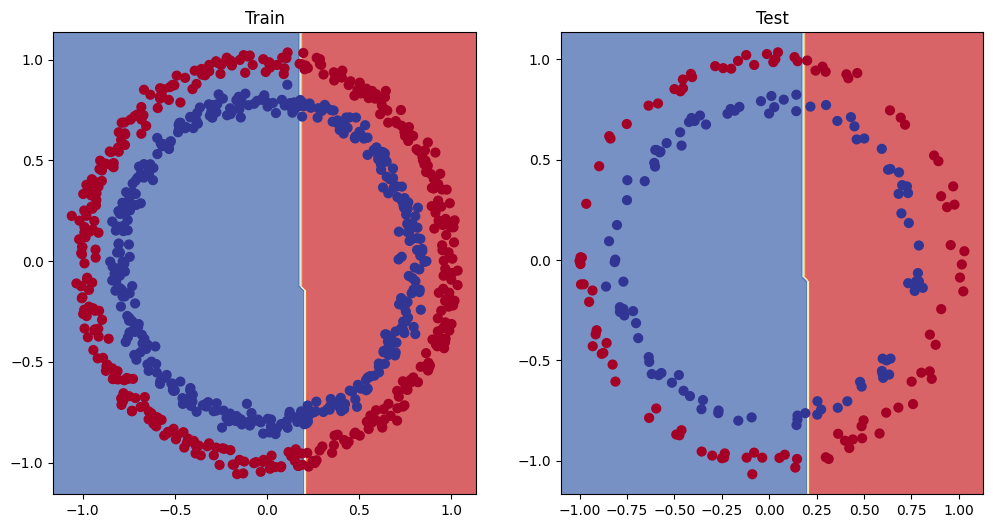

In [18]:
# Lets see the improvements 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,y_test)

### The missing piece : Non-linearity

The model is well off in drawing linear line , but is unable to draw non-linear line and that's where activation comes in.

Sarting off fresh with new data.


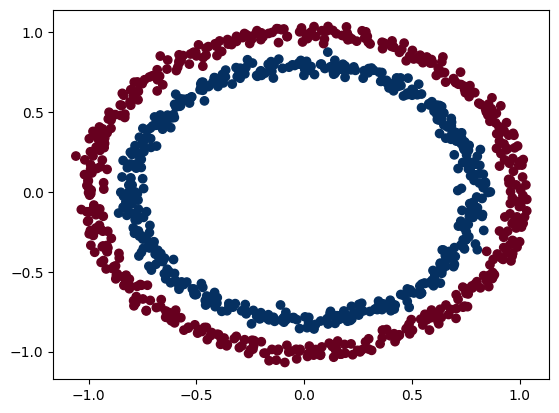

In [19]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[: ,1], c = y ,cmap = plt.cm.RdBu)

In [20]:
# splitting data to train and test
from sklearn.model_selection import train_test_split

# convert data to tensor
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# splitting 
X_train, X_test, y_train, y_test = train_test_split(x,y ,random_state=42,
                                                    test_size=0.2)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [22]:
# Model with activation 
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Activation 

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2 = CircleModelV2()
model_2.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
# Loss and Optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lr = 0.01, params=model_2.parameters())

In [25]:
# Fit the model
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
   
    y_logits = model_2(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    

    loss = loss_fn(y_logits.squeeze(), y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_preds=y_pred.squeeze())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():

      test_logits = model_2(X_test)
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = loss_fn(test_logits.squeeze(), y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_preds=test_pred.squeeze())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69441, Accuracy: 0.50% | Test Loss: 0.69274, Test Accuracy: 0.50%
Epoch: 100 | Loss: 0.15242, Accuracy: 1.00% | Test Loss: 0.18243, Test Accuracy: 0.99%
Epoch: 200 | Loss: 0.01130, Accuracy: 1.00% | Test Loss: 0.02717, Test Accuracy: 1.00%
Epoch: 300 | Loss: 0.00461, Accuracy: 1.00% | Test Loss: 0.01690, Test Accuracy: 1.00%
Epoch: 400 | Loss: 0.00261, Accuracy: 1.00% | Test Loss: 0.01222, Test Accuracy: 1.00%
Epoch: 500 | Loss: 0.00171, Accuracy: 1.00% | Test Loss: 0.00995, Test Accuracy: 1.00%
Epoch: 600 | Loss: 0.00121, Accuracy: 1.00% | Test Loss: 0.00860, Test Accuracy: 1.00%
Epoch: 700 | Loss: 0.00091, Accuracy: 1.00% | Test Loss: 0.00773, Test Accuracy: 1.00%
Epoch: 800 | Loss: 0.00071, Accuracy: 1.00% | Test Loss: 0.00708, Test Accuracy: 1.00%
Epoch: 900 | Loss: 0.00057, Accuracy: 1.00% | Test Loss: 0.00672, Test Accuracy: 1.00%


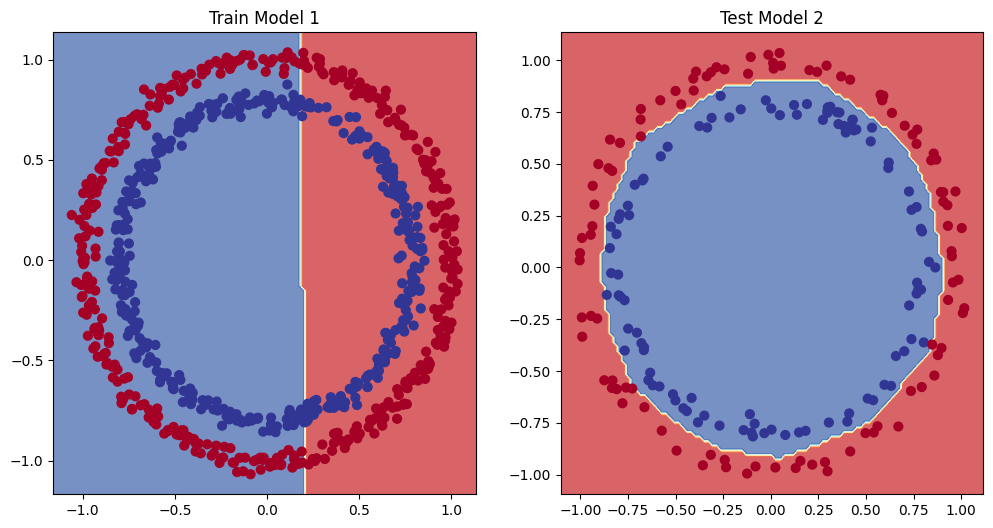

In [28]:
# Plotting 
# Model 1 vs Model 2 ie Without activtion and with activation


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Model 1")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test Model 2")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

### Replicating activation function (For fun!)

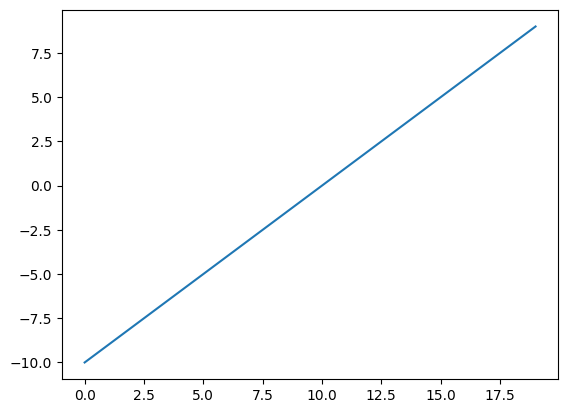

In [33]:
# Creating toy tensor 

A = torch.arange(-10, 10, 1, dtype = torch.float)

plt.plot(A)

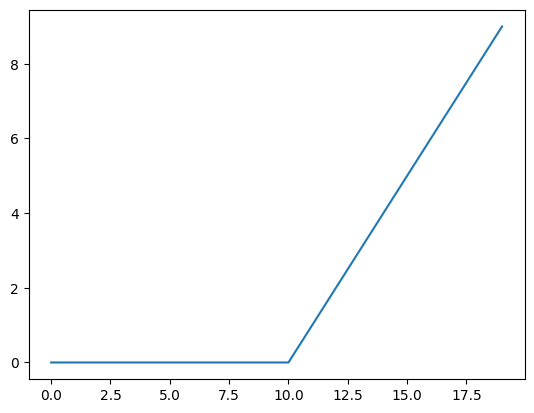

In [34]:
# ReLU

def relu(x):
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

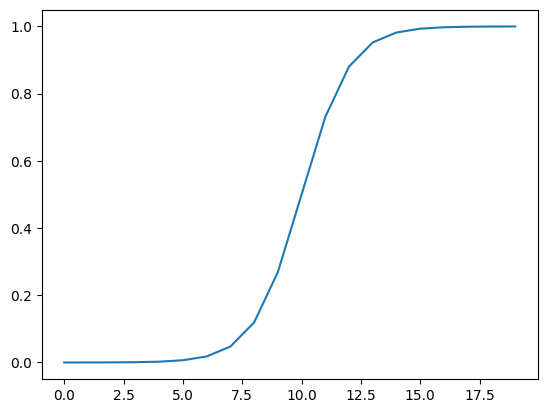

In [35]:
# Sigmoid

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))